# Introduction à l'apprentissage par renforcement
# TP 1 - les manchots multi-bras

Etudiant·e : AJOUTER VOTRE NOM ICI

1/4 de la note finale est liée à la mise en forme : 

* pensez à nettoyer les outputs inutiles (installation, messages de débuggage, ...)
* soignez vos figures : les axes sont-ils faciles à comprendre ? L'échelle est adaptée ? 
* commentez vos résultats : vous attendiez-vous à les avoir ? Est-ce étonnant ? Faites le lien avec la théorie.

Ce TP reprend l'exemple d'un médecin et de ses vaccins. Vous allez comparer plusieurs stratégies et trouver celle optimale.
Un TP se fait en groupe de 2 à 4. Aucun groupe de plus de 4 personnes. 

Vous allez rendre le TP dans une archive ZIP. L'archive ZIP contient ce notebook au format `ipynb`, mais aussi exporté en PDF & HTML. 
L'archive ZIP doit aussi contenir un fichier txt appelé `groupe.txt` sous le format:

```
Nom1, Prenom1, Email1, NumEtudiant1
Nom2, Prenom2, Email2, NumEtudiant2
Nom3, Prenom3, Email3, NumEtudiant3
Nom4, Prenom4, Email4, NumEtudiant4
```

Un script vient extraire vos réponses : ne changez pas l'ordre des cellules et soyez sûrs que les graphes sont bien présents dans la version notebook soumise. 

In [1]:
! pip install matplotlib tqdm numpy ipympl opencv-python
!jupyter labextension install @jupyter-widgets/jupyterlab-manager
!jupyter labextension install jupyter-matplotlib

Building jupyterlab assets (production, minimized)
Building jupyterlab assets (production, minimized)


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 

import typing as t
import math
import torch
import numpy as np
from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import cv2
from IPython.display import display, clear_output

torch.random.manual_seed(0)

K = 5 # num arms

# Présentation du problème

In [133]:
class ArmBernoulli:
    def __init__(self, p: float, random_state: t.Optional[int] = None):
        """
        Vaccine treatment following a Bernoulli law (mean is p and variance is p(1-p)
        Args:
             p (float): mean parameter
             random_state (int): seed to make experiments reproducible
             
        >>> arm = ArmBernoulli(0.5, 0)
        >>> arm.sample(5)
        tensor([ True, False,  True,  True,  True])
        """
        if random_state is not None:
            torch.random.manual_seed(random_state)
        self.immunity_rate = p

    def sample(self, n: int = 1):
        return torch.rand(n) < self.immunity_rate
    
    def __repr__(self):
        return f'<ArmBernoulli p={self.immunity_rate}' 

def generate_arms(num_arms: int):
    means = torch.rand(num_arms)
    MAB = [ArmBernoulli(m) for m in means]
    assert MAB[0].immunity_rate == means[0]
    assert (MAB[0].sample(10) <= 1).all() and (MAB[0].sample(10) >= 0).all() 
    return MAB

MAB = generate_arms(K)

**Note importante :** pour la suite, les tests seront faits avec 10 MAB différents ou plus pour réduire le bruit de simulation. 

Ce TP reprend l'exemple du médecin présenté en cours.


**Q1. Que vaut $\mu^*$ avec `random_state = 0`? Comment est définie la récompense $R_k$ ? Que représente concrètement le regret dans cet exemple ?**

In [322]:
import random

def get_index_patients(patients_list: list[int], vaccin: int):
    indexes = []
    for index, value in enumerate(patients_list):
        if (value == vaccin):
            indexes.append(index) 
    return indexes

class Simulation:
    def __init__(self, N: int, M: int, nbr_vaccins: int):
        """
        """
        self.N = N
        self.M = M
        self.nbr_vaccins = nbr_vaccins
        self.vaccins_list = generate_arms(nbr_vaccins)
        self.patients_list_of_vaccins = self.get_patients_list_of_vaccins()
        self.mu_star = self.get_mu_star()
        self.patients_immunity = self.get_patients_immunity()
        self.sum_R_k = self.get_sum_R_k()
        

    def get_patients_list_of_vaccins(self):
        list_patient = [
            random.randint(1,self.nbr_vaccins) if i < self.N
            else 0
            for i in range(self.N + self.M)
        ]
        return list_patient
    
    def get_mu_star(self):
        mu_tensor = [vaccin.immunity_rate for vaccin in self.vaccins_list]
        mu_list = [i.item() for i in mu_tensor]
        return max(mu_list)
    
    def get_patients_immunity(self):
        vaccin_use = self.get_vaccin_use()
        patients_immunity = [0 for patient in self.patients_list_of_vaccins]
        
        for index, vaccin in enumerate(self.vaccins_list):
            samples = vaccin.sample(vaccin_use[index]).int()
            samples = samples.tolist()
            all_patients = get_index_patients(self.patients_list_of_vaccins, index+1)  
            for s, index in zip(samples, all_patients):
                patients_immunity[index] = s
          
        return patients_immunity
    
    def get_sum_R_k(self):
        return sum(self.patients_immunity)
    
    def get_vaccin_use(self):
        vaccin_use = [0 for i in range(self.nbr_vaccins)]
        for patient in self.patients_list_of_vaccins:
            if patient >0:
                vaccin_use[patient-1]+=1
        return vaccin_use
    
    def get_reward_vaccin(self, vaccin_index):
        reward = 0
        for patient_vaccin, immunity in zip(self.patients_list_of_vaccins, self.patients_immunity):
            if (patient_vaccin == vaccin_index and immunity):
                reward+=1
        return reward
    
    def get_immunization_rate(self):
        vaccin_use = self.get_vaccin_use()
        immunization_rate = [
            0 if vaccin_use[index] == 0
            else 
            1/vaccin_use[index]*self.get_reward_vaccin(index+1) 
            for index, vaccin in enumerate(self.vaccins_list)
        ]
        return immunization_rate
    
    def get_vaccin_with_best_rate(self):
        rates = self.get_immunization_rate()
        best_rate = max(rates)
        return rates.index(best_rate)+1
    
    def update_exploration(self):
        vaccin = self.get_vaccin_with_best_rate()
        self.patients_list_of_vaccins = [
            patient if index < self.N
            else vaccin
            for patient, index in zip(self.patients_list_of_vaccins, range(self.N + self.M))
        ]
        self.update_immunity()
        return self
        
    def update_immunity(self):
        self.patients_immunity = self.get_patients_immunity()
        self.sum_R_k = self.get_sum_R_k()
        return self.patients_immunity
    
    
#s = Simulation(5, 5, 5)
#print(s.patients_immunity)
#print(s.get_immunization_rate())
#print(s.get_vaccin_with_best_rate())
#print(s.update_exploration())
#print(s.update_immunity())

def get_regret(simulation: Simulation):
    """      
    """     
    return (simulation.N+simulation.M) * simulation.mu_star - simulation.sum_R_k
    
#get_regret(s)

La récompense $R_k$ de chaque bras de la simulation est définie comme une distribution de Bernouilli de paramètre $\mu_k$. Ainsi la moyenne $\hat{\mu}_k$ de chaque bras est égale à l'espérance de la distribution de Bernouilli de paramètre $\mu_k$, elle est donc égale au paramètre $p=\mu_k$.

Ainsi, $\mu^*$ qui correspond à la récompense moyenne du meilleur vaccin $i$, correspond donc à $max(\mu_k)$ et la récompense $R_k$ est équivalente à $R_k=B(p=\mu_k)$.

Concrétement, le regret correspond à: $r_N=N\mu^*-\sum\limits _{k=0} ^{N-1}R_k$.
Il s'agit donc de l'écart entre N fois la moyenne et tout les patient immunisé. Il s'agit donc de l'écart entre le nombre de patient immunisé s'ils avaient pris le meilleur vaccin $i$ et le nombre de patient immunisé dans la simulation.

# I. Cas classique des bandits manchots 

## I.a. Solution Gloutonne

Le médecin fonctionne sur deux phases :

1. **Exploration :** N patients reçoivent une dose d'un vaccin choisi aléatoirement. Le médecin calcule le taux d'immunisation empirique :

$$\bar{R_i} = \frac{1}{T_i} \sum_{k=0}^{N-1} \chi_{v_k,i}R_k,$$

avec $T_i = \sum_{k=0}^{N-1} \chi_{v_k,i}$.


2. **Exploitation :** Le vaccin $v_i = \arg\max_j \bar{R_j}$ est utilisé pour les M patients suivants. C'est la phase de test.

**Q2. Implémentez la solution gloutonne avec N = 50 et M = 500 et testez la avec 100 MAB différents (tous ont 5 vaccins). On s'intéresse à la variable aléatoire "la phase d'exploration a trouvé le bon vaccin". Quelle est l'espérance empirique de cette variable ? Et son écart-type ? Calculez de même l'espérance et l'écart-type du regret sur vos 100 simulations.**

Pour rappel, le regret est défini par :

$$r_n = n\mu^* - \sum_{k=0}^{n-1} R_k$$

**Attention :** $n$ est le nombre total de patients, donc ici $N + M$.

In [323]:
simulations = [Simulation(50, 500, 5) for i in range(100)]
for simulation in simulations:
    simulation.update_exploration()
    
#exploration à trouvé le bon vaccin
#calculé espérance et écart type
# + espérance et écart type du regret

**Q3. On propose d'améliorer l'algorithme précédant en mettant à jour les taux d'immunisation empiriques $\bar{R}_i$ pendant la d'exploration. Notez vous une amélioration du regret ? Proposez un exemple dans lequel cette mise à jour ne changera rien.** 

*[Ajoutez votre commentaire ici]*

**Q4. Créez une figure contenant deux sous-figures : à gauche, le taux d'immunisation empirique $\bar{R}_i$ pour les 5 vaccins ; à droite, le regret $r_n$. La figure sera animée avec les patients : chaque frame $k$ de l'animation représente le vaccin que l'on donne au $k$-ième patient.**

In [ ]:
#left Ri for each vaccin depending on k
#regret

#k frame

##import numpy as np
##import matplotlib.pyplot as plt
##color = ['red', 'green', 'blue', 'orange']
##fig = plt.figure()
##plt.xticks(rotation=45, ha="right", rotation_mode="anchor") #rotate the x-axis values
##plt.subplots_adjust(bottom = 0.2, top = 0.9) #ensuring the dates (on the x-axis) fit in the screen
##plt.ylabel('No of Deaths')
##plt.xlabel('Dates')


##def buildmebarchart(i=int):
##    plt.legend(df1.columns)
##    p = plt.plot(df1[:i].index, df1[:i].values) #note it only returns the dataset, up to the point i
##    for i in range(0,4):
##        p[i].set_color(color[i]) #set the colour of each curve
##import matplotlib.animation as ani
##animator = ani.FuncAnimation(fig, buildmebarchart, interval = 100)
##plt.show()

*[Ajoutez votre commentaire ici]*

**Q5. On étudie maintenant l'influence de la taille du training set $N$. On considère que N+M est une constante, puis on fait varier N entre K et M. Calculez le regret pour ces différentes tailles du training set  différents MAB et representez le regret moyen, le regret min et max (vous devriez trouver une courbe en U ou en V pour le regret moyen). Quelle est la taille optimale du training set ?**

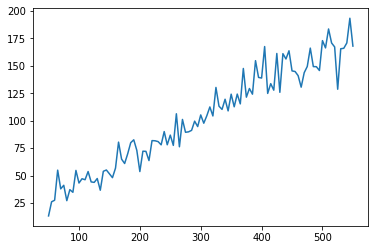

In [327]:
import numpy as np
import matplotlib.pyplot as plt

#suppose M+N = 600
# N varie de 50 550
# M varie de 550 à 50
multiverse = []
for K in range (50, 555, 5):
    N = K
    M = 600 - K
    simulations = [Simulation(N, M, 5) for i in range(10)]
    simulations = [simulation.update_exploration() for simulation in simulations]
    regrets = [get_regret(simulation) for simulation in simulations]
    multiverse.append((regrets, K))

mean_regrets = [(sum(regrets)/len(regrets), K) for regrets, K in multiverse]
#min_regrets = [(min(regrets), K) for regrets, K in multiverse]
#max_regrets = [(max(regrets), K) for regrets, K in multiverse]
    
#print(mean_regrets)

x = [mean for mean, K in mean_regrets]
y = [K for mean, K in mean_regrets]

#print(x)
#print(y)

plt.plot(y, x)

#plt.show() # affiche la figure à l'écran


*[Ajoutez votre commentaire ici]*

## I.b. Borne inférieure de Lai & Robbins [Lai et Robbins, 1985]

Pour un modèle de manchot de Bernoulli (équivalent au problème étudié), la borne inférieure de Lai et Robbins [Lai et Robbins, 1985] stipule que :

$$\lim \inf_{n\rightarrow \infty} \frac{\sum_{k=0}^{n-1} R_k}{\log n} \geq \sum_{i~\text{tel que}~\mu_i \lt \mu^*} \frac{\mu^∗−\mu_i}{\text{KL}(\mu_i, \mu^*)}  :=C(\mu)$$
 
 avec $\text{KL}(x, y) = x \log(x/y) + (1 − x) \log((1 − x)/(1 − y))$ (distance de Kullback-Leibler) et  $\sum_{k=0}^{n-1} R_k$ la récompense obtenue sur $n$ patients (avec un algorithme optimal). 
 
 
**Q6. Justifiez pourquoi cette borne signifie que la machine optimale est jouée exponentiellement plus souvent que les autres machines.**

*[Ajoutez votre commentaire ici]*

**Q7. Tracez le regret issu de la borne de Lai & Robbins et comparez le au regret obtenu avec l'algorithme glouton.**

*[Ajoutez votre commentaire ici]*

## I.c. Upper Confidence Bounds

Cet algorithme améliore la version précédente en ajoutant un biais lié à la fréquentation de chaque vaccin :

$$\hat{R}_i = \bar{R}_i + \sqrt{\frac{C\log{n}}{T_i}}$$,

avec $C=2$.

**Q8. Implémentez la modification de cette algorithme. Conservez les deux phases exploration/exploitation décrites ci-dessus. En prenant les valeurs de $N$ et $M$ trouvées à la question Q5, quel regret obtenez-vous ? Faites l'expérience avec au moins 10 MAB différents (tous ayant 5 vaccins) afin de calculer la moyenne et l'écart-type du regret.**

*[Ajoutez votre commentaire ici]*

**Q9. Reprenez la questions Q4 avec cette algorithme. Dans la figure de gauche, vous representerez $\bar{R}_i$ et $\hat{R}_i$.**

*[Ajoutez votre commentaire ici]*

**Q10. Reprenez la question Q5 avec cette algorithme. Concluez sur l'utilité (ou l'inutilité) de la phase d'exploration. Comparez les performances d'UCB avec celles de l'algorithme glouton.**

*[Ajoutez votre commentaire ici]*

**Q11. Testez différentes valeurs pour $C$ et trouvez sa valeur optimale expérimentalement.**

*[Ajoutez votre commentaire ici]*

# Echantillonnage de Thomson

Cet algorithme propose de modéliser la variable aléatoire de chaque vaccin avec une loi $\beta$ dont les paramètres $a$ et $b$ correspondent au nombre de patients que le vaccin a immunisés (resp. non immunisés).

Pour chaque patient, on tire un valeur aléatoire pour la loi $\beta$ décrivant chaque vaccin, puis on choisit le vaccin avec la plus grande valeur tirée. 

**Q12. Implémentez cet algorithme. Conservez les deux phases exploration/exploitation décrites ci-dessus. En prenant les valeurs de $N$ et $M$ trouvées à la question Q5, quel regret obtenez-vous ? Faites l'expérience avec au moins 10 MAB différents (tous ayant 5 vaccins) afin de calculer la moyenne et l'écart-type du regret.**

*[Ajoutez votre commentaire ici]*

**Q13. Reprenez la question Q4, mais cette fois-ci, vous representerez le taux d'immunisation empirique avec un [graphique en violon](https://en.wikipedia.org/wiki/Violin_plot) qui représente la loi beta associée à chaque vaccin.**

*[Ajoutez votre commentaire ici]*

**Q14. Représentez son regret pour différentes tailles du training set (comme dans la Q5). Comparez le regret avec les autres algorithmes.**

*[Ajoutez votre commentaire ici]*

# Conclusion

**Q15. Calculez le regret des algorithmes glouton, UCB & Thomson lorsqu'il y a un grand nombre de vaccins disponibles (K=100) (on prendra N=100). Faites le lien avec la [malédiction de la dimension](https://fr.wikipedia.org/wiki/Fl%C3%A9au_de_la_dimension).**

*[Ajoutez votre commentaire ici]*